# DTI Based Tumor Simulation

The input for this solver is a DTI file and the output is a 3D tumor concentration. 

The dimensions of the input is x,y,z,6 for a lower symmetric tensor ([dxx, dxy, dyy, dxz, dyz, dzz]). 

In [3]:
import sys
sys.path.append('/Users/azhylka/Projects/TumorGrowthToolkit/TumorGrowthToolkit')
from TumorGrowthToolkit.FK_DTI import FK_DTI_Solver
from TumorGrowthToolkit.FK import Solver as FK_Solver
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import time
import scipy.ndimage
import nibabel as nib
import os
from scipy.ndimage import binary_dilation
import TumorGrowthToolkit.FK_DTI.tools as tools

## Load the provided DTI file.


(240, 240, 155, 3, 3)


Text(0.5, 1.0, 'Tissue segmentation')

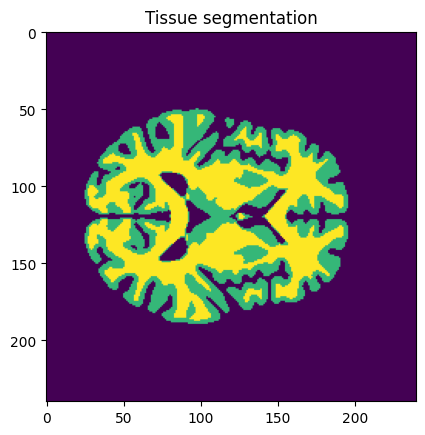

In [5]:
tissueSegmentationPath = "./dataset/sub-mni152_tissue-with-antsN4_space-sri.nii.gz"
tensorPath = "./dataset/FSL_HCP1065_tensor_1mm_space-HPC-AntsIndexSpace_SRI.nii.gz"

originalTissue = nib.load(tissueSegmentationPath).get_fdata()
affine = nib.load(tissueSegmentationPath).affine

#create a 3x3 tensor for each voxel
tissueTensor = tools.get_tensor_from_lower6(nib.load(tensorPath).get_fdata()[:,:,:,0,:])

CSFMask = originalTissue == 1 # binary_dilation(originalTissue == 1, iterations = 1)

tissue = originalTissue.copy()
tissue[CSFMask] = 0
tissueTensor[CSFMask] = 0

plt.imshow(tissue[:,:,75])
plt.title("Tissue segmentation")


## Set the parameters for the simulation

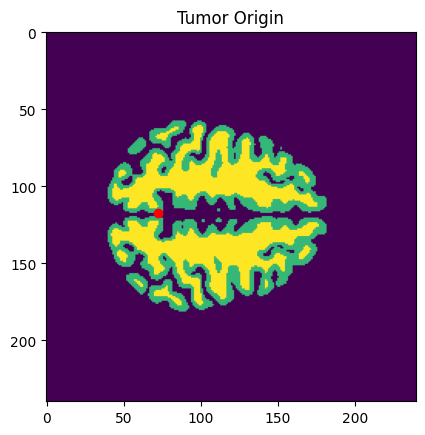

In [6]:

dw = 1
rho = 0.2#2
#ventricle
"""x = 0.6
y = 0.3
z = 0.50"""
x = 0.49
y = 0.30
z = 0.7

init_scale = 0.1
resolution_factor = 1# 0.6#1
stoppingVolume =  15000
parameters = {
    'Dw': dw,          # maximum diffusion coefficient
    'rho': rho,        # Proliferation rate
    'diffusionTensors':tissueTensor, # diffusion tissue map as shown above
    'diffusionTensorExponent': 1, # exponent for the diffusion tensor, 1.0 for linear relationship
    'diffusionEllipsoidScaling':1,#21.713178343886213,
    'NxT1_pct': x,    # tumor position [%]
    'NyT1_pct': y,
    'NzT1_pct': z,
    'init_scale': init_scale, #scale of the initial gaussian
    'resolution_factor': resolution_factor, #resultion scaling for calculations
    'verbose': True, #printing timesteps 
    'time_series_solution_Nt': 64, # number of timesteps in the output
    'stopping_volume': stoppingVolume,
    'stopping_time': 1000,
}

x = int(tissue.shape[0]*parameters["NxT1_pct"])
y = int(tissue.shape[1]*parameters["NyT1_pct"])
z = int(tissue.shape[2]*parameters["NzT1_pct"])

plt.imshow(tissue[:,:,z])
plt.scatter(y,x, c='r')
plt.title("Tumor Origin")
plt.show()

## Run the solver
This might take a few minutes depending on the settings.

diffusionEllipsoidScaling: 1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].


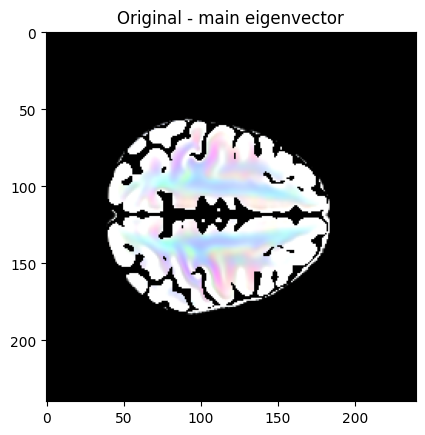

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..2.0].


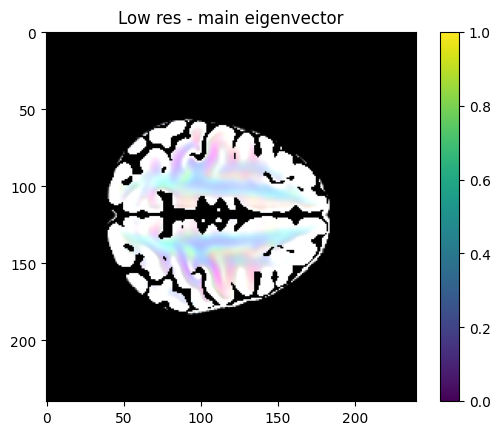

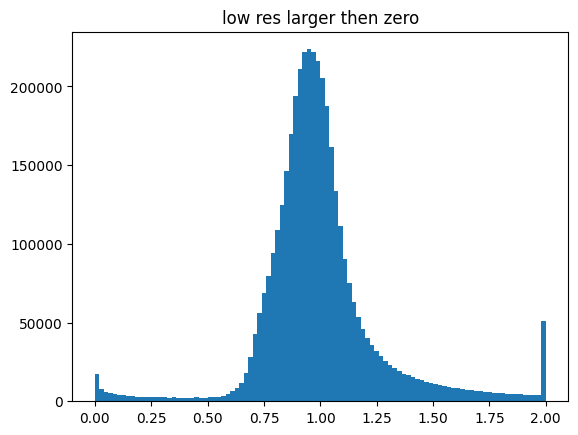

Number of simulation timesteps: 16100
init:  (240, 240, 155) Volume of init Tumor 0.5019612661942862


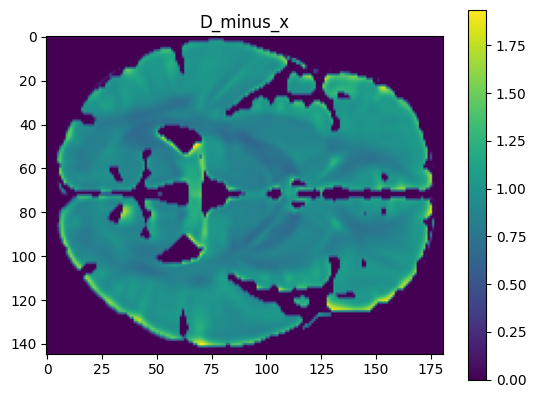

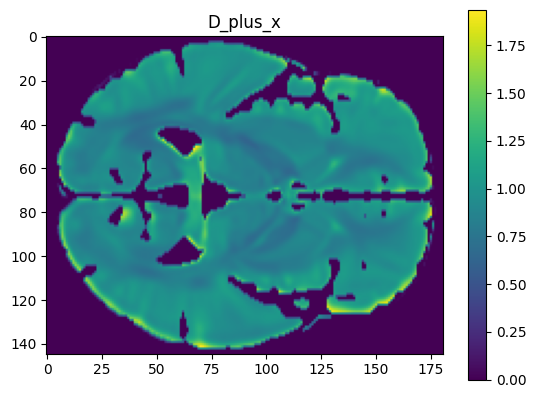

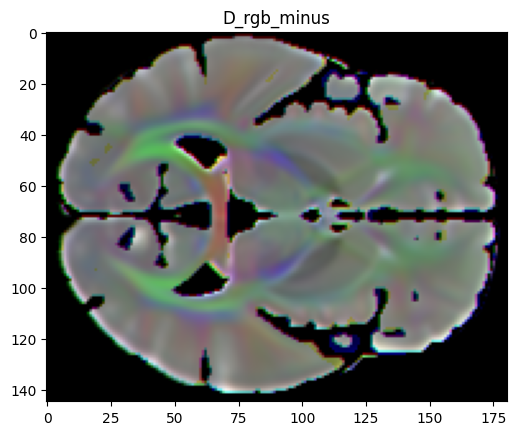

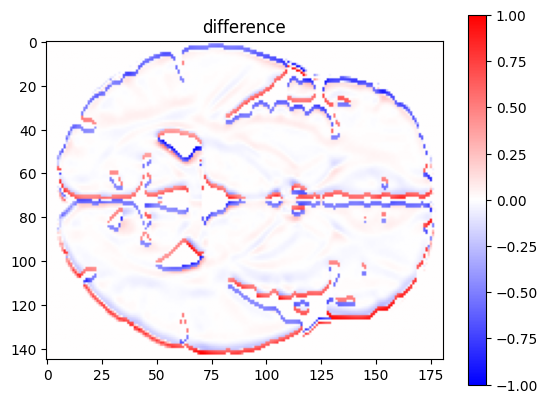

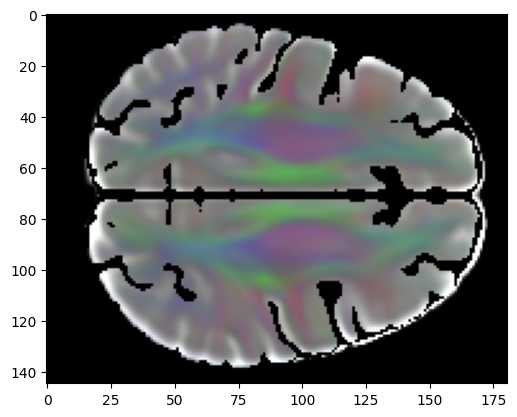

Execution Time: 51 seconds
Simulation successful!


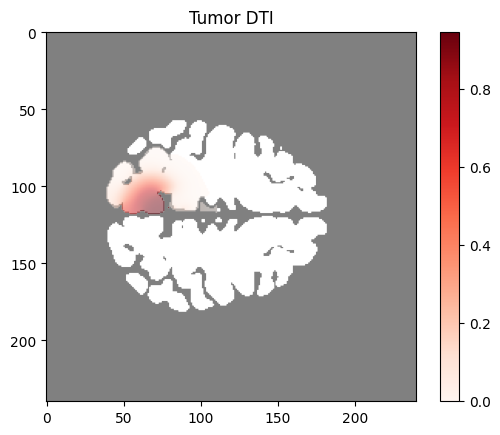

In [7]:
# Run the DTI_FK_solver and plot the results
start_time = time.time()
fK_DTI_Solver = FK_DTI_Solver(parameters)
result = fK_DTI_Solver.solve(doPlot=True)
end_time = time.time()  # Store the end time
execution_time = int(end_time - start_time)  # Calculate the difference

print(f"Execution Time: {execution_time} seconds")
if result['success']:
    print("Simulation successful!")
else:
    print("Error occurred:", result['error'])

plt.imshow(tissue[:,:,z]>0,alpha=0.5*(tissue[:,:,z]==0), cmap='gray')
plt.imshow(result['final_state'][:,:,z], alpha=0.5*(result['final_state'][:,:,z]>0.001), cmap = "Reds")	
plt.colorbar()
plt.title('Tumor DTI')
plt.show()

## Compare to the FK model

In [8]:
gm = tissue == 2
wm = tissue == 3
gm[CSFMask] = 0
wm[CSFMask] = 0
parametersFK = {
    'Dw': dw,          # maximum diffusion coefficient
    'rho': rho,        # Proliferation rate
    'gm' : gm,
    'wm' : wm,
    'NxT1_pct': parameters["NxT1_pct"],    # tumor position [%]
    'NyT1_pct': parameters["NyT1_pct"],
    'NzT1_pct': parameters["NzT1_pct"],
    'init_scale': init_scale, #scale of the initial gaussian
    'resolution_factor': resolution_factor, #resultion scaling for calculations
    'verbose': True, #printing timesteps 
    'time_series_solution_Nt': 64, # number of timesteps in the output
    'stopping_volume': stoppingVolume,
    'stopping_time': 1000,
}


fkSolver = FK_Solver(parametersFK)
resultFK = fkSolver.solve()

Number of simulation timesteps: 8100


# Final Tumor Comparison

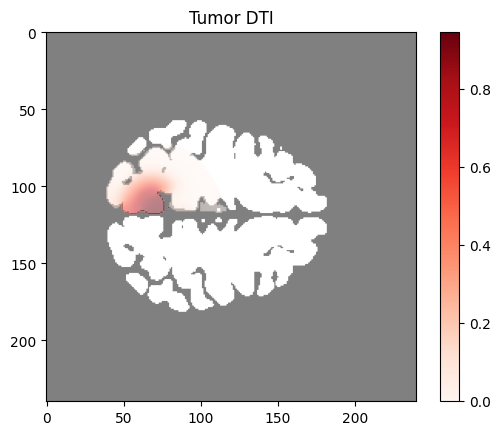

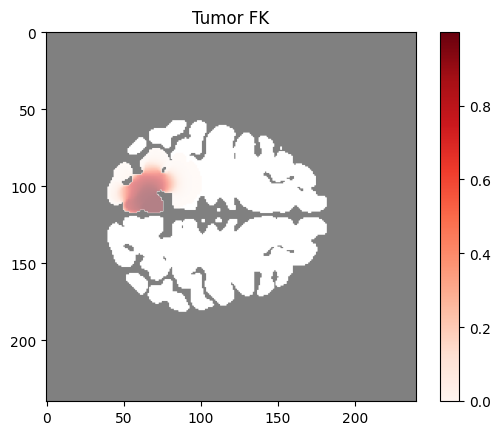

In [9]:

plt.imshow(tissue[:,:,z]>0,alpha=0.5*(tissue[:,:,z]==0), cmap='gray')
plt.imshow(result['final_state'][:,:,z], alpha=0.5*(result['final_state'][:,:,z]>0.0001), cmap = "Reds")	
plt.colorbar()
plt.title('Tumor DTI')
plt.show()
plt.imshow(tissue[:,:,z]>0,alpha=0.5*(tissue[:,:,z]==0), cmap='gray')
plt.imshow(resultFK['final_state'][:,:,z], alpha=0.5*(resultFK['final_state'][:,:,z]>0.0001), cmap = "Reds")	

plt.title('Tumor FK')
plt.colorbar()
plt.show()